In [2]:
# This document is for making 3D plots of MHD-AEPIC runs, using both PIC and MHD data. 
# The PIC data and MHD data can be read in at two different cadences. The PIC data overrides the MHD data

# Essential Jupyter Notebook Magic
%matplotlib inline

# General Purpose and Data Handling Libraries
import os
import re
import glob
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from natsort import natsorted
import pickle
from operator import add
import random
import math

# MatPlotlib for Plotting and Visualization
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.tri as tri
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib import cm, ticker
from matplotlib.colors import LogNorm, LightSource, ListedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import LogFormatter, LogFormatterSciNotation
from matplotlib.ticker import LogLocator, MultipleLocator, NullFormatter
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import Axes3D
from streamtracer import StreamTracer, VectorGrid
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from cmap import Colormap
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import SymLogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# Scipy for Scientific Computing and Analysis
from scipy import stats, interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d, griddata
from scipy.ndimage import label, gaussian_filter
from scipy.spatial import ConvexHull
from scipy.interpolate import RegularGridInterpolator
from skimage import measure
from shapely.geometry import Polygon
from scipy.ndimage import zoom

# Image Handling and Processing
from PIL import Image

# Tecplot for Scientific Data Visualization
import tecplot as tp
from tecplot.exception import *
from tecplot.constant import *

# For 3d plotting
from skimage import measure


In [3]:
# Define Constants
amu = 1.67e-27
k_b = 1.38e-23
mu_0 = 1.257e-6
R_M = 2440e3 #m
m_p = 1.67e-27 # kg
e = 1.60218e-19 # C

# Define utility functions
def read_dataset(mypath,port=7600):
    # Reads in file "mypath" and returns a dataset object. May take a while for larger files.

    print("reading:",mypath)
    # First connect to TecPlot
    tp.session.connect(port=port)

    # Configure layout
    tp.new_layout()
    dataset = tp.data.load_tecplot(mypath)
    frame = tp.active_frame()
    frame.plot_type = PlotType.Cartesian3D

    # Return dataset
    return dataset

def Bz_dip(x_array,y_array,z_array):
    # Input: arrays of x,y,z (in planet centered coords).
    # Output: Bz at each point
    
    return - 200.9 * (3*(z_array-0.2)**2 - (x_array**2+y_array**2+(z_array-0.2)**2))/((x_array**2+y_array**2+(z_array-0.2)**2)**(5/2))

def get_files(dir, start_time, t_bound, dt, key=".*cut_particle_region0_0.*", read_time = False, reduce = True):
    # For a directory "dir", return a list of all files which match the regex expression "key"
    
    all_files = [f for f in listdir(dir) if isfile(join(dir, f))]
    files=[]
    for file in all_files:
        match = re.search(key,file)
        if match != None:
            files.append(file)
    files.sort()

    # Now give them the appropriate name for their time
    # If we haven't already named these files with their time, do that now
    named_files = {}
    if read_time == False:
        for i in range(len(files)):
            time = round(i*dt+start_time,3)
            named_files[time] = files[i]
    # Otherwise, read the time right from the (last 6 elements) filename
    else:
        for i in range(len(files)):
            time = str("%.2f"%float(files[i][-6:]))
            named_files[time] = files[i]

    # Now cut the list down to files inside t_bound
    if reduce:
        reduced_files = {}
        for file_time in list(named_files.keys()):#[int((t_bound[0]-start_time)/dt):int((t_bound[1]-start_time)/dt)]: #only loop over the times within t_bound
            if t_bound[0]<=float(file_time)<t_bound[1]:
                reduced_files[file_time] = str(named_files[file_time])
        return reduced_files

    else:
        return named_files

def dat_to_plt(dir,files):
    # Hand it a directory with the dict of files in it, and it will convert them to .plt and save in dir
    
    for file in files:
        dataset=read_dataset(str(dir+files[file]))
        print("saving file:",str(dir+files[file][:-3]+"plt"))
        tp.data.save_tecplot_plt(str(dir+files[file][:-3]+"plt"))
        os.remove(str(dir+files[file]))
        print(f"Deleted original .dat file: {files[file]}")

def plt_to_numpy(dataset,var_ls=["Bz"],save_cs = True):
    # Input: the path to a .plt file, and a list of variables to convert into a numpy meshgrid
    # Output: a dictionary of arrays, each labelled according to its name in var_ls
    # Var_ls should be *extensive*, so that this long process does not need to be rerun

    # Extract the coordinate axes
    x_axis = np.unique(dataset.variable("X").values(0).as_numpy_array())
    y_axis = np.unique(dataset.variable("Y").values(0).as_numpy_array())[1:-1]
    z_axis = np.unique(dataset.variable("Z").values(0).as_numpy_array())

    # Create an ordered zone
    rect_zone = dataset.add_ordered_zone('rect_zone',[len(x_axis),len(y_axis-2),len(z_axis)])

    # Create 3D coordinate meshgrids
    xxx,yyy,zzz = np.meshgrid(x_axis,y_axis,z_axis)

    # Assign coordinate values to the rect_zone using the meshgrids
    rect_zone.values('X')[:] = xxx.ravel()
    rect_zone.values('Y')[:] = yyy.ravel()
    rect_zone.values('Z')[:] = zzz.ravel()

    # Compute derivatives in tecplot, which does it efficiently
    # Compute current density, in A/m^2
    if ("Jx" in var_ls) or ("Jy" in var_ls) or ("Jz" in var_ls):
        print("Computing J = ∇xB")
        tp.data.operate.execute_equation(equation='{Jx} = (ddy({Bz}) - ddz({By}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jy} = (ddz({Bx}) - ddx({Bz}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jz} = (ddx({By}) - ddy({Bx}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)

    # Compute plasma pressure gradient, in nPa / m
    if ("dp_dx" in var_ls) or ("dp_dy" in var_ls) or ("dp_dz" in var_ls):
        print("Computing ∇$p$")
        tp.data.operate.execute_equation(equation='{dp_dx} = (ddx({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
        ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dy} = (ddy({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dz} = (ddz({pxxS1}+{pxxS0}+{pyyS1}+{pyyS0}+{pzzS1}+{pzzS0}))/3/2440000',
            ignore_divide_by_zero=True)
        
    # Compute magnetic field gradient , in nT / m
    if ("dB_dx" in var_ls) or ("dB_dy" in var_ls) or ("dB_dz" in var_ls): 
        print("Computing ∇B")
        tp.data.operate.execute_equation(equation='{dB_dx} = (ddx(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dy} = (ddy(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dz} = (ddz(({Bx}*{Bx}+{By}*{By}+{Bz}*{Bz})**(0.5)))/2440000',
            ignore_divide_by_zero=True)

    # Compute advective derivative (u . del) u
    if ("duix_dx" in var_ls):
        print("Computing jacobian for $(u_i\cdot∇)u_i$")
        tp.data.operate.execute_equation(equation='{duix_dx} = (ddx({uxS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiy_dx} = (ddx({uyS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiz_dx} = (ddx({uzS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duix_dy} = (ddy({uxS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiy_dy} = (ddy({uyS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiz_dy} = (ddy({uzS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duix_dz} = (ddz({uxS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiy_dz} = (ddz({uyS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duiz_dz} = (ddz({uzS1}))/2440000', # km/s /m
            ignore_divide_by_zero=True)

    print("Beginning interpolation...")
    # Interpolate onto rect_zone
    tp.data.operate.interpolate_linear(source_zones=[0],
        destination_zone=1,
        fill_value=0)

    # Define dictionary to save results
    data3d = {"X":xxx,"Y":yyy,"Z":zzz}

    # All all variables to data
    for var in var_ls:
        data3d[var] = rect_zone.values(var).as_numpy_array().reshape(xxx.shape)

    # Save in place
    print("Extraction complete! Saving 3D data ...")
    save_file = open(str(dir+file[:-4]+"_numpy_t_"+'{:06.2f}'.format(round(time,2))), 'wb') 
    pickle.dump(data3d, save_file) 
    print("Done!")

    if save_cs:
        #Calculate the plasma beta meshgrid
        beta_meshgrid = (2*mu_0*(rect_zone.values("pxxS0").as_numpy_array()+rect_zone.values("pyyS0").as_numpy_array()+rect_zone.values("pzzS0").as_numpy_array()+rect_zone.values("pxxS1").as_numpy_array()+
                                rect_zone.values("pyyS1").as_numpy_array()+rect_zone.values("pzzS1").as_numpy_array())*1e9/3/(rect_zone.values("Bx").as_numpy_array()**2+rect_zone.values("By").as_numpy_array()**2+rect_zone.values("Bz").as_numpy_array()**2)).reshape(xxx.shape)
        beta_meshgrid[np.isnan(beta_meshgrid)] = -1
        
         # New code: extract all of the Z coords, smooth them, and then find the values interpolated to those points!
        data = {"X":xxx[:,:,0],"Y":yyy[:,:,0]} #, "Z":np.zeros_like(xxx[:,:,0])}
        print("Saving cs data...")
        # Define empty array to save the unsmoothed Z values to
        Z_rough = np.zeros_like(xxx[:,:,0])+0.2
        # At each x/y, find the z coord of max beta and save that
        for idy in range(len(yyy[:,0,0])):
            for idx in range(len(xxx[0,:,0])):
                # If any of the beta values in this column are -1 near the middle, that means we are at the inner edge of the bounding box
                # In this case, set the data value to 0 to let me know where the boundary is!
                if np.min(beta_meshgrid[idy,idx,len(z_axis)//4:-len(z_axis)//4]) == -1:
                    Z_rough[idy,idx] = 0.2
                else:
                    idz = np.argmax(beta_meshgrid[idy,idx,:])
                    Z_rough[idy,idx] = zzz[idy,idx,idz]
    
        # Smoothing parameter
        smoothing_param = 5
        # Smooth the Z meshgrid
        data['Z'] = smooth_meshgrid(xxx[:,:,0], yyy[:,:,0], Z_rough, smoothing_param)
    
        # Use this as a template to extract all the other data with
        for name in var_ls:
            data[name] = np.zeros_like(xxx[:,:,0])
    
            # Extract each variable from tecplot as an array
            var = rect_zone.values(name).as_numpy_array().reshape(xxx.shape)
    
            # At each x/y, find the z coord of max beta and save that
            for idy in range(len(yyy[:,0,0])):
                for idx in range(len(xxx[0,:,0])):
                    # If any of the beta values in this column are -1 near the middle, that means we are at the inner edge of the bounding box
                    # In this case, set the data value to 0 to let me know where the boundary is!
                    if np.min(beta_meshgrid[idy,idx,len(z_axis)//4:-len(z_axis)//4]) == -1:
                        data[name][idy,idx] = 0
                    else:
                        # Find the indices of the two nearest points
                        lower_idz = np.searchsorted(zzz[idy,idx,:], data['Z'][idy,idx]) - 1
                        upper_idz = lower_idz + 1
    
                        # Get the coordinates of the nearest points
                        Z_lower = zzz[idy,idx,lower_idz]
                        Z_upper = zzz[idy,idx,upper_idz]
                        var_lower = var[idy,idx,lower_idz]
                        var_upper = var[idy,idx,upper_idz]
                        
                        # Perform linear interpolation
                        data[name][idy,idx] = var_lower + (var_upper - var_lower) * (data['Z'][idy,idx] - Z_lower) / (Z_upper - Z_lower)
    
        print("Done!")
        save_file = open(str(dir+file[:-4]+"_csdata_t_"+'{:06.2f}'.format(round(time,2))), 'wb') 
        pickle.dump(data, save_file) 

def MHD_to_numpy(dataset,x_axis,y_axis,z_axis,var_ls=["Bz"],save_cs = True, smoothing_param = 5/8):
    # Input: the path to a .plt file, and a list of variables to convert into a numpy meshgrid
    # Output: a dictionary of arrays, each labelled according to its name in var_ls
    # Var_ls should be *extensive*, so that this long process does not need to be rerun

    # Create an ordered zone`
    rect_zone = dataset.add_ordered_zone('rect_zone',[len(x_axis),len(y_axis),len(z_axis)])

    # Create 3D coordinate meshgrids
    xxx,yyy,zzz = np.meshgrid(x_axis,y_axis,z_axis)

    # Assign coordinate values to the rect_zone using the meshgrids
    rect_zone.values('X [[]R[]]')[:] = xxx.ravel()
    rect_zone.values('Y [[]R[]]')[:] = yyy.ravel()
    rect_zone.values('Z [[]R[]]')[:] = zzz.ravel()

    # Compute derivatives in tecplot, which does it efficiently
    # Compute plasma pressure gradient, in nPa / m
    if ("dp_dx" in var_ls) or ("dp_dy" in var_ls) or ("dp_dz" in var_ls):
        print("Computing ∇$p$")
        tp.data.operate.execute_equation(equation='{dp_dx} = {P [[]nPa[]]}/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dy} = (ddy({P [[]nPa[]]}))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dp_dz} = (ddz({P [[]nPa[]]}))/2440000',
            ignore_divide_by_zero=True)
        
    # Compute magnetic field gradient , in nT / m
    if ("dB_dx" in var_ls) or ("dB_dy" in var_ls) or ("dB_dz" in var_ls): 
        print("Computing ∇B")
        tp.data.operate.execute_equation(equation='{dB_dx} = (ddx(({B_x [[]nT[]]}*{B_x [[]nT[]]}+{B_y [[]nT[]]}*{B_y [[]nT[]]}+{B_z [[]nT[]]}*{B_z [[]nT[]]})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dy} = (ddy(({B_x [[]nT[]]}*{B_x [[]nT[]]}+{B_y [[]nT[]]}*{B_y [[]nT[]]}+{B_z [[]nT[]]}*{B_z [[]nT[]]})**(0.5)))/2440000',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dB_dz} = (ddz(({B_x [[]nT[]]}*{B_x [[]nT[]]}+{B_y [[]nT[]]}*{B_y [[]nT[]]}+{B_z [[]nT[]]}*{B_z [[]nT[]]})**(0.5)))/2440000',
            ignore_divide_by_zero=True)

    # Compute advective derivative (u . del) u
    if ("dux_dx" in var_ls):
        print("Computing jacobian for $(u_i\cdot∇)u_i$")
        tp.data.operate.execute_equation(equation='{dux_dx} = (ddx({U_x [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duy_dx} = (ddx({U_y [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duz_dx} = (ddx({U_z [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dux_dy} = (ddy({U_x [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duy_dy} = (ddy({U_y [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duz_dy} = (ddy({U_z [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{dux_dz} = (ddz({U_x [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duy_dz} = (ddz({U_y [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{duz_dz} = (ddz({U_z [km/s]}))/2440000', # km/s /m
            ignore_divide_by_zero=True)

    print("Beginning interpolation...")
    # Interpolate onto rect_zone
    tp.data.operate.interpolate_linear(source_zones=[0],
        destination_zone=1,
        fill_value=0)

    # Define dictionary to save results
    data3d = {"X":xxx,"Y":yyy,"Z":zzz}

    # All all variables to data
    for var in var_ls:
        data3d[var] = rect_zone.values(var).as_numpy_array().reshape(xxx.shape)

    # Save in place
    print("Extraction complete! Saving 3D data ...")
    save_file = open(str(dir+file[:-4]+"_numpy_t_"+'{:06.2f}'.format(round(time,2))), 'wb') 
    pickle.dump(data3d, save_file) 
    print("Done!")

    if save_cs:
        #Calculate the plasma beta meshgrid
        beta_meshgrid = (2*mu_0*rect_zone.values("P [[]nPa[]]").as_numpy_array()*1e9/(rect_zone.values("B_x [[]nT[]]").as_numpy_array()**2+rect_zone.values("B_y [[]nT[]]").as_numpy_array()**2+rect_zone.values("B_z [[]nT[]]").as_numpy_array()**2)).reshape(xxx.shape)
        beta_meshgrid[np.isnan(beta_meshgrid)] = -1
        
         # New code: extract all of the Z coords, smooth them, and then find the values interpolated to those points!
        data = {"X":xxx[:,:,0],"Y":yyy[:,:,0]} #, "Z":np.zeros_like(xxx[:,:,0])}
        print("Saving cs data...")
        # Define empty array to save the unsmoothed Z values to
        Z_rough = np.zeros_like(xxx[:,:,0])+0.2
        # At each x/y, find the z coord of max beta and save that
        for idy in range(len(yyy[:,0,0])):
            for idx in range(len(xxx[0,:,0])):
                # If any of the beta values in this column are -1 near the middle, that means we are at the inner edge of the bounding box
                # In this case, set the data value to 0 to let me know where the boundary is!
                if np.min(beta_meshgrid[idy,idx,len(z_axis)//4:-len(z_axis)//4]) == -1:
                    Z_rough[idy,idx] = 0.2
                else:
                    idz = np.argmax(beta_meshgrid[idy,idx,:])
                    # Sse 0.2 if it tries to go too far away from the magnetic equator
                    if (np.abs(zzz[idy,idx,idz] - 0.2)>0.2):
                        Z_rough[idy,idx] = 0.2
                    else:
                        Z_rough[idy,idx] = zzz[idy,idx,idz]
    
        # Smooth the Z meshgrid
        data['Z'] = smooth_meshgrid(xxx[:,:,0], yyy[:,:,0], Z_rough, smoothing_param)
    
        # Use this as a template to extract all the other data with
        for name in var_ls:
            data[name] = np.zeros_like(xxx[:,:,0])
    
            # Extract each variable from tecplot as an array
            var = rect_zone.values(name).as_numpy_array().reshape(xxx.shape)
    
            # At each x/y, find the z coord of max beta and save that
            for idy in range(len(yyy[:,0,0])):
                for idx in range(len(xxx[0,:,0])):
                    # If any of the beta values in this column are -1 near the middle, that means we are at the inner edge of the bounding box
                    # In this case, set the data value to 0 to let me know where the boundary is!
                    if np.min(beta_meshgrid[idy,idx,len(z_axis)//4:-len(z_axis)//4]) == -1:
                        data[name][idy,idx] = 0
                    else:
                        # Find the indices of the two nearest points
                        lower_idz = np.searchsorted(zzz[idy,idx,:], data['Z'][idy,idx]) - 1
                        upper_idz = lower_idz + 1
    
                        # Get the coordinates of the nearest points
                        Z_lower = zzz[idy,idx,lower_idz]
                        Z_upper = zzz[idy,idx,upper_idz]
                        var_lower = var[idy,idx,lower_idz]
                        var_upper = var[idy,idx,upper_idz]
                        
                        # Perform linear interpolation
                        data[name][idy,idx] = var_lower + (var_upper - var_lower) * (data['Z'][idy,idx] - Z_lower) / (Z_upper - Z_lower)
    
        print("Done!")
        save_file = open(str(dir+file[:-4]+"_csdata_t_"+'{:06.2f}'.format(round(time,2))), 'wb') 
        pickle.dump(data, save_file) 


def smooth_meshgrid(X, Y, Z, smoothing_param):
    """
    Smooth the Z values of a meshgrid defined by X, Y coordinates using a Gaussian filter.
    
    Parameters:
    X (2D numpy array): The X coordinates of the meshgrid.
    Y (2D numpy array): The Y coordinates of the meshgrid.
    Z (2D numpy array): The Z coordinates of the meshgrid.
    smoothing_param (float): The standard deviation for the Gaussian kernel, controlling the smoothing.
    
    Returns:
    Z_smoothed (2D numpy array): The smoothed Z values of the meshgrid.
    """
    # Check if X, Y, Z are of the same shape
    if X.shape != Y.shape or X.shape != Z.shape:
        raise ValueError("X, Y, and Z meshgrids must have the same shape")
    
    # Apply Gaussian filter to the Z meshgrid
    Z_smoothed = gaussian_filter(Z, sigma=smoothing_param)
    
    return Z_smoothed

def plot_sphere(ax, u = np.linspace(0, 2 * np.pi, 200), v = np.linspace(0, np.pi, 100), radius=1, center=(0, 0, 0), color='b', alpha=0.5, zorder = 1, xlims = [-10,10], ylims = [-10,10], zlims = [-10,10]):
    """
    Plots a sphere of given radius centered at center on the provided 3D axis.
    
    Parameters:
    - ax: The 3D axis to plot the sphere on.
    - radius: The radius of the sphere (default: 1).
    - center: The (x, y, z) coordinates of the sphere's center (default: (0, 0, 0)).
    - color: The color of the sphere (default: blue).
    - alpha: The transparency of the sphere (default: 0.5).
    """
    x = radius * np.outer(np.cos(u), np.sin(v)) + center[0]
    y = radius * np.outer(np.sin(u), np.sin(v)) + center[1]
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]

    # Mask out any values outside the axes lims
    mask = (x < xlims[0]) | (x > xlims[1]) | (y < ylims[0]) | (y > ylims[1]) | (z < zlims[0]) | (z > zlims[1]) 
    x[mask] = np.nan
    y[mask] = np.nan
    z[mask] = np.nan

    ax.plot_surface(x, y, z, color=color, alpha=alpha, zorder=zorder)

def average_value(var_ls,t0,t_start,t_stop,type='csdata'):
    # Input: Variables to average, the current time (t0), and the times relative to present to average over (t0+t_start to t0+t_stop)
    # Ouput: dictionary of arrays of time-averaged values

    averages = {}
    count = 0

    temp_files = get_files(dir,key="3d\_fluid.*"+type+"\_t\_...\...",read_time = True, reduce = False)

    for t in list(temp_files.keys()): 
        # Check to see if this file is in the time range we want
        if (float(t) >= (t0+t_start)) and (float(t) <= t0+t_stop):
            temp_file = str(temp_files[t])
    
            # Read in this data
            with open(dir+temp_file, 'rb') as f:
                temp_data = pickle.load(f) 
            
            # Add the data to our running average for each variable
            for var in var_ls:
                if var not in averages.keys():
                    averages[var] = temp_data[var]
                else:
                    averages[var] += temp_data[var]

            count += 1
        
    # Divide by total time steps
    for var in var_ls:
        averages[var] = averages[var]/count

    return averages

def find_indices(X, Y, XX, YY):
    # Function used to get ix and iy for some coordinates X and Y
    X = np.array(X)
    Y = np.array(Y)
    XX = np.array(XX)
    YY = np.array(YY)

    ix = []
    iy = []
    
    for (x, y) in zip(X, Y):
        # Find the closest index in the meshgrid for the x coordinate
        ix_index = np.abs(XX[0] - x).argmin()
        # Find the closest index in the meshgrid for the y coordinate
        iy_index = np.abs(YY[:, 0] - y).argmin()
        
        ix.append(ix_index)
        iy.append(iy_index)
        
    return iy, ix

def remove_duplicate_rows(arr):
    # Used in df_tracker... does something to remove repeated rows in the matching matrix
    seen = set()
    filtered_rows = []
    for row in arr:
        if row[0] not in seen:
            filtered_rows.append(row)
            seen.add(row[0])
    return np.array(filtered_rows)

def find_boundary_points(X, Y):
    # Combine the coordinate lists into a single array of points
    points = np.column_stack((X, Y))

    # Compute the convex hull of the points
    hull = ConvexHull(points)

    # Extract the boundary points
    boundary_points = hull.vertices

    # Boundary points in original coordinate lists
    boundary_X = points[boundary_points, 0]
    boundary_Y = points[boundary_points, 1]

    return boundary_X.tolist(), boundary_Y.tolist()

def create_above_surface_mask(X, Y, Z, XX, YY, ZZ):
    # Works out all the 3D points above a 2D surface ie all the points above the current sheet.
    # Used for 3D plotting to determine what is above what.
    # Check that XX, YY, ZZ have the same shape
    assert XX.shape == YY.shape == ZZ.shape, "Arrays XX, YY, and ZZ must have the same shape"
    
    # Check that X, Y, Z have the same shape
    assert X.shape == Y.shape == Z.shape, "Arrays X, Y, and Z must have the same shape"

    # Determine the shape of the input arrays
    nx, ny, nz = XX.shape

    # Initialize a mask with the same shape as ZZ
    mask = np.zeros_like(ZZ, dtype=bool)

    # Iterate over the entire 3D meshgrid
    for i in range(nx):
        for j in range(ny):
            # Find the index in the 2D arrays corresponding to the x and y coordinates
            xi = np.argmin(np.abs(X[0] - XX[i, j, 0]))
            yi = np.argmin(np.abs(Y[:, 0] - YY[i, j, 0]))

            # Compare ZZ with Z to determine the mask
            mask[i, j, :] = ZZ[i, j, :] > Z[yi, xi]

    return mask


def compute_dt(var_ls,time,type='csdata'):
    # Input: variables to compute the time derivative for, and the current time
    # Output: dictionary of time derivatives for each variable, calculated as dvar_dt = var(time+dt)-var(time-dt)/(2*dt)
    # If earlier or later times are not available, we do either var(time+dt)-var(time)/dt or var(time)-var(time-dt)/dt

    # Declare output dictionary
    deriv_dict = {}
    #print("Computing time derivatives at time",time)
    key_minus = '{:.2f}'.format((float(time)-dt), 'wb')
    key_plus = '{:.2f}'.format((float(time)+dt), 'wb')
    #print(files.keys())
    #print(key_minus)
    #print(key_plus)

    if type=='csdata':
        temp_files = filescs
        data = datacs
    elif type=='numpy':
        temp_files = files3D
        data = data3d

    # Read in the data depending on whether its available
    if (key_minus in temp_files.keys()) and (key_plus in temp_files.keys()):
        # Case one: earlier and later timestep available, so use both
        #print("Earlier and later timesteps available!")
        with open(dir+temp_files[key_minus], 'rb') as f:
            data_tminus = pickle.load(f) 
        with open(dir+temp_files[key_plus], 'rb') as f:
            data_tplus = pickle.load(f) 
        for var in var_ls:
            deriv_dict[var] = (data_tplus[var]-data_tminus[var])/(2*dt)
    
    elif (key_minus in temp_files.keys()):
        # Case two: only earlier time available
        #print("Only earlier timestep available!")
        with open(dir+temp_files[key_minus], 'rb') as f:
            data_tminus = pickle.load(f) 
        for var in var_ls:
            deriv_dict[var] = (data[var]-data_tminus[var])/(dt)

    elif (key_plus in temp_files.keys()):
        # Case three: only later time available
        #print("Only later timestep available!")
        print(dir+temp_files[key_plus])
        with open(dir+temp_files[key_plus], 'rb') as f:
            data_tplus = pickle.load(f) 
        for var in var_ls:
            deriv_dict[var] = (data_tplus[var]-data[var])/(dt)

    else:
        print("ERROR: NO OTHER TIMESTEPS FOUND FOR DERIVATIVE AT TIME =",time)
            
    return deriv_dict

def plane_intersection(x, y, z, plane_z=0.2):
    # Used in 3D_df_tracker2 to check whether a given field line intersects the current sheet multiple times or not
    intersections = 0  # Counter for intersections with the plane

    # Iterate over the list of points
    for i in range(1, len(z)):
        if (z[i-1] - plane_z) * (z[i] - plane_z) < 0:
            # There is an intersection between z[i-1] and z[i] since their signs are different
            intersections += 1
        elif z[i-1] == plane_z and z[i] != plane_z:
            # Edge case: the point is exactly on the plane
            intersections += 1

    return intersections

def symlog(x):
    """ Returns the symmetric log10 value """
    return np.sign(x) * np.log10(np.abs(x))

def symroot(x):
    """ Returns the symmetric sqrt value """
    return np.sign(x) * np.sqrt(np.abs(x))

# Functions for adding arrows; use "setattr(Axes3D, 'arrow3D', _arrow3D)" after defining your axes
class Arrow3D(FancyArrowPatch):
            def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
                super().__init__((0, 0), (0, 0), *args, **kwargs)
                self._xyz = (x, y, z)
                self._dxdydz = (dx, dy, dz)
        
            def draw(self, renderer):
                x1, y1, z1 = self._xyz
                dx, dy, dz = self._dxdydz
                x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)
        
                xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
                self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
                super().draw(renderer)
                
            def do_3d_projection(self, renderer=None):
                x1, y1, z1 = self._xyz
                dx, dy, dz = self._dxdydz
                x2, y2, z2 = (x1 + dx, y1 + dy, z1 + dz)
        
                xs, ys, zs = proj_transform((x1, x2), (y1, y2), (z1, z2), self.axes.M)
                self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
                
                return np.min(zs) 
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)

In [201]:
############################## PREPROCESSING ##############################
#dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-2e/"
dir = "/Volumes/My Book Duo/runs/nightside_v5_run1/ta-2/"
pre_proc_MHD = True
MHD_start_time = 40  # First time step of MHD data saved in this directory
t_bound = [40,60]    # Start and stop times of this data to be plot (cannot go beyond available PIC data time range)
MHD_dt = 1 # File time cadence of MHD data [s]
preproc_xlims = [-10,4]
preproc_ylims = [-5,5]
preproc_zlims = [-5,5]
MHD_var_ls = ["Rho [[]amu/cm^3[]]","U_x [[]km/s[]]","U_y [[]km/s[]]","U_z [[]km/s[]]","B_x [[]nT[]]","B_y [[]nT[]]","B_z [[]nT[]]",
             "P [[]nPa[]]","J_x [[]`mA/m^2[]]","J_y [[]`mA/m^2[]]","J_z [[]`mA/m^2[]]"]#,"dp_dx","dp_dy","dp_dz",
              #"dB_dx","dB_dy","dB_dz","dux_dx","duy_dx","duz_dx","dux_dy","duy_dy","duz_dy","dux_dz","duy_dz","duz_dz"]

PIC_var_ls = ["Bx","By","Bz","Ex","Ey","Ez","rhoS0","uxS0","uyS0","uzS0","pxxS0","pyyS0","pzzS0","pxyS0","pxzS0","pyzS0",
          "rhoS1","uxS1","uyS1","uzS1","pxxS1","pyyS1","pzzS1","pxyS1","pxzS1","pyzS1","Jx","Jy","Jz","dp_dx","dp_dy","dp_dz",
          "dB_dx","dB_dy","dB_dz","duix_dx","duiy_dx","duiz_dx","duix_dy","duiy_dy","duiz_dy","duix_dz","duiy_dz","duiz_dz"]

# Cell data from PIC (found by directly examining the actual output grid)
PIC_xmin = -3.99219
PIC_ymin = -1.22656
PIC_zmin = -0.742188
PIC_dx = 0.01562501
dx_factor = 4 # The MHD grid will be limited to steps of this size factor 
PIC_dx1 = PIC_dx * dx_factor

############################## PREPROCESSING ##############################

if pre_proc_MHD:
    xmin_idx = int(round((PIC_xmin - preproc_xlims[0])/PIC_dx1,0)) # How many PIC_dx between PIC_xmin and preproc_xlims[0]
    ymin_idx = int(round((PIC_ymin - preproc_ylims[0])/PIC_dx1,0))
    zmin_idx = int(round((PIC_zmin - preproc_zlims[0])/PIC_dx1,0))
    xmax_idx = int(round((preproc_xlims[1] - PIC_xmin)/PIC_dx1,0))
    ymax_idx = int(round((preproc_ylims[1] - PIC_ymin)/PIC_dx1,0))
    zmax_idx = int(round((preproc_zlims[1] - PIC_zmin)/PIC_dx1,0))

    MHD_xlims = [PIC_xmin - xmin_idx*PIC_dx1, PIC_xmin + xmax_idx*PIC_dx1]
    MHD_ylims = [PIC_ymin - ymin_idx*PIC_dx1, PIC_ymin + ymax_idx*PIC_dx1]
    MHD_zlims = [PIC_zmin - zmin_idx*PIC_dx1, PIC_zmin + zmax_idx*PIC_dx1]

    MHD_xaxis = np.arange(MHD_xlims[0],MHD_xlims[1]+PIC_dx1,PIC_dx1)
    MHD_yaxis = np.arange(MHD_ylims[0],MHD_ylims[1]+PIC_dx1,PIC_dx1)
    MHD_zaxis = np.arange(MHD_zlims[0],MHD_zlims[1]+PIC_dx1,PIC_dx1)
    
    MHD_files = get_files(dir,MHD_start_time,t_bound,MHD_dt,key="3d\_\_var\_3\_t.*\.plt",reduce = True)
    for time in list(MHD_files.keys()): 
        print("Preprocessing MHD data for t =",time)
        file = str(MHD_files[time])
    
        # Read in dataset
        dataset = read_dataset(dir+file,port=7605)
        # Save .plt as numpy data
        data = MHD_to_numpy(dataset,MHD_xaxis,MHD_yaxis,MHD_zaxis,var_ls=MHD_var_ls)
    

Preprocessing MHD data for t = 40
reading: /Volumes/My Book Duo/runs/nightside_v5_run1/ta-2/3d__var_3_t00000040_n00263576.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7605
Connection established.
Beginning interpolation...
Extraction complete! Saving 3D data ...
Done!
Saving cs data...


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_90441/1566400592.py:309: RuntimeWarning: invalid value encountered in divide
  beta_meshgrid = (2*mu_0*rect_zone.values("P [[]nPa[]]").as_numpy_array()*1e9/(rect_zone.values("B_x [[]nT[]]").as_numpy_array()**2+rect_zone.values("B_y [[]nT[]]").as_numpy_array()**2+rect_zone.values("B_z [[]nT[]]").as_numpy_array()**2)).reshape(xxx.shape)


Done!
Preprocessing MHD data for t = 41
reading: /Volumes/My Book Duo/runs/nightside_v5_run1/ta-2/3d__var_3_t00000041_n00267876.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7605
Connection established.
Beginning interpolation...
Extraction complete! Saving 3D data ...
Done!
Saving cs data...
Done!
Preprocessing MHD data for t = 42
reading: /Volumes/My Book Duo/runs/nightside_v5_run1/ta-2/3d__var_3_t00000042_n00272136.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7605
Connection established.
Beginning interpolation...
Extraction complete! Saving 3D data ...
Done!
Saving cs data...
Done!
Preprocessing MHD data for t = 43
reading: /Volumes/My Book Duo/runs/nightside_v5_run1/ta-2/3d__var_3_t00000043_n00276366.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7605
Connection established.
Beginning interpolation...
Extraction complete! Saving 3D data ...
Done!
Saving cs data...
Done!
Preprocessing MHD data for t = 44
reading: 

In [61]:
############################## USER INPUT ##############################

# Plotting control parameters
# Directory data
dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-234e/"   # Directory with data 
#dir = "/Volumes/My Book Duo/runs/nightside_v5_run1/ta-2/"

# Time range: this sets the times and timing of the plots
t_bound = [42,60]    # Start and stop times of this data to be plot (cannot go beyond available PIC data time range)
PIC_start_time = 30  # First time step of PIC data saved in this directory
MHD_start_time = 40  # First time step of MHD data saved in this directory
PIC_dt = 0.05  # File time cadence of PIC data [s]
MHD_dt = 1 # File time cadence of MHD data [s]
cell_size = R_M/64  # Edge length of Pic cell, in m

# Spatial range: this sets the spatial extent of the data to be loaded in
xlims = [-6.5,3.5]
ylims = [-4,4.5]
zlims = [-1,1.2]

# Zoom region: where the data should be zoomed to view
xlims_zoom = [-3,-1]
ylims_zoom = [-1.5,1.5]
zlims_zoom = [0,1]

# Viewing angle
azim = -150
elev = 30

# Smoothing scale (best to use 8, which is standard for PIC postproc)
smoothing_param = 8

# Testing -- enable if data is already read in and we are just adjusting a plot
plot_testing = True

# Plot presets
plot_preset = "hybrid_Jy"
'''
"hybrid_Bz1": Bz1 in stated domain.

"hybrid_Jy": Jy in stated domain.
'''

############################## USER INPUT ##############################

var_matching = {"X":"X","Y":"Y","Z":"Z",
                "Bx":"B_x [[]nT[]]","By":"B_y [[]nT[]]","Bz":"B_z [[]nT[]]",
                "Ex":None,"Ey":None,"Ez":None,
                "rhoS0":"Rho [[]amu/cm^3[]]",
                "uxS0":None,"uyS0":None,"uzS0":None,
                "pxxS0":None,"pyyS0":None,"pzzS0":None,"pxyS0":None,"pxzS0":None,"pyzS0":None,
                "rhoS1":"Rho [[]amu/cm^3[]]",
                "uxS1":"U_x [[]km/s[]]","uyS1":"U_y [[]km/s[]]","uzS1":"U_z [[]km/s[]]",
                "pxxS1":None,"pyyS1":None,"pzzS1":None,"pxyS1":None,"pxzS1":None,"pyzS1":None,
                "Jx":"J_x [[]`mA/m^2[]]","Jy":"J_y [[]`mA/m^2[]]","Jz":"J_z [[]`mA/m^2[]]",
                "dp_dx":"dp_dx","dp_dy":"dp_dy","dp_dz":"dp_dz",
                "dB_dx":"dB_dx","dB_dy":"dB_dy","dB_dz":"dB_dz",
                "duix_dx":"dux_dx","duiy_dx":"duy_dx","duiz_dx":"duz_dx",
                "duix_dy":"dux_dy","duiy_dy":"duy_dy","duiz_dy":"duz_dy",
                "duix_dz":"dux_dz","duiy_dz":"duy_dz","duiz_dz":"duz_dz"}

In [62]:
# Begin plotting
# Get all the files in the time range
PIC_files_3D = get_files(dir,PIC_start_time,t_bound,PIC_dt,key="3d\_fluid.*numpy\_t\_...\...",read_time = True,reduce = True)
PIC_files_cs = get_files(dir,PIC_start_time,t_bound,PIC_dt,key="3d\_fluid.*csdata\_t\_...\...",read_time = True,reduce = True)
MHD_files_3D = get_files(dir,MHD_start_time,t_bound,MHD_dt,key="3d\_\_var\_3\_t.*numpy\_t\_...\...",read_time = True,reduce = True)
MHD_files_cs = get_files(dir,MHD_start_time,t_bound,MHD_dt,key="3d\_\_var\_3\_t.*csdata\_t\_...\...",read_time = True,reduce = True)

# Begin iteration loop
iter = 0
print("Plotmode:",plot_preset)
for time_str in list(PIC_files_3D.keys()): 
    time = float(time_str)
    print("Plotting t =",time)

    ############################## DATASET FORMATION START ##############################

    if not plot_testing:
        # Read in the 3D PIC data
        my_file = str(PIC_files_3D[time_str])
        with open(dir+my_file, 'rb') as f:
            PIC_data_3D = pickle.load(f) 
    
        # Read in the cs PIC data
        my_file = str(PIC_files_cs[time_str])
        with open(dir+my_file, 'rb') as f:
            PIC_data_cs = pickle.load(f) 
    
        # Compute the coordinate axes for the data
        if iter==0:
            dx_ls = []
            for i in range(1,len(PIC_data_3D['X'][0,:,0])):
            
                dx_ls.append(PIC_data_3D['X'][0,i,0] - PIC_data_3D['X'][0,i-1,0])
            PIC_dx = np.mean(dx_ls)
            
            xmin_idx = int(round((np.min(PIC_data_3D['X']) - xlims[0])/PIC_dx,0)) # How many PIC_dx between PIC_xmin and preproc_xlims[0]
            ymin_idx = int(round((np.min(PIC_data_3D['Y']) - ylims[0])/PIC_dx,0))
            zmin_idx = int(round((np.min(PIC_data_3D['Z']) - zlims[0])/PIC_dx,0))
            xmax_idx = int(round((xlims[1] - np.min(PIC_data_3D['X']))/PIC_dx,0))
            ymax_idx = int(round((ylims[1] - np.min(PIC_data_3D['Y']))/PIC_dx,0))
            zmax_idx = int(round((zlims[1] - np.min(PIC_data_3D['Z']))/PIC_dx,0))
            
            corrected_xlims = [np.min(PIC_data_3D['X']) - xmin_idx*PIC_dx, np.min(PIC_data_3D['X']) + xmax_idx*PIC_dx]
            corrected_ylims = [np.min(PIC_data_3D['Y']) - ymin_idx*PIC_dx, np.min(PIC_data_3D['Y']) + ymax_idx*PIC_dx]
            corrected_zlims = [np.min(PIC_data_3D['Z']) - zmin_idx*PIC_dx, np.min(PIC_data_3D['Z']) + zmax_idx*PIC_dx]
            
            x_axis = np.arange(corrected_xlims[0],corrected_xlims[1]+PIC_dx,PIC_dx)
            y_axis = np.arange(corrected_ylims[0],corrected_ylims[1]+PIC_dx,PIC_dx)
            z_axis = np.arange(corrected_zlims[0],corrected_zlims[1]+PIC_dx,PIC_dx)
            print("Total number of cells to load:", x_axis.shape[0]*y_axis.shape[0]*z_axis.shape[0])
    
        # Create data structures for the desired spatial range
        data3D={}
        datacs={}
    
        # Check if we need to load in MHD data to fill gaps (usually is the case)
        add_MHD = np.min(PIC_data_3D['X']) > corrected_xlims[0] or np.min(PIC_data_3D['X']) < corrected_xlims[0] or np.min(PIC_data_3D['Y']) > corrected_ylims[0] or np.max(PIC_data_3D['Y']) < corrected_ylims[1] or np.min(PIC_data_3D['Z']) > corrected_zlims[0] or np.max(PIC_data_3D['Z']) < corrected_zlims[1]
        if add_MHD:
            # Determine the closest available MHD time
            MHD_time = min(list(MHD_files_3D.keys()), key=lambda s: abs(float(s) - time))
            print("MHD_TIME:",MHD_time)
            # Read in 3D MHD data
            my_file = str(MHD_files_3D[MHD_time])
            with open(dir+my_file, 'rb') as f:
                MHD_data_3D = pickle.load(f)
            # Read in cs MHD data
            my_file = str(MHD_files_cs[MHD_time])
            with open(dir+my_file, 'rb') as f:
                MHD_data_cs = pickle.load(f)
    
            # Determine the scale factor used for MHD data compression
            dx_factor = int(round((MHD_data_cs['X'][0,1] - MHD_data_cs['X'][0,0])/PIC_dx,0))
    
        # Move all of the PIC data into the correct slots
        for key, var_data in PIC_data_3D.items():
            #if key in ['X', 'Y', 'Z']:
            #    continue
            # If we are adding MHD data, we use that as our baseline to overwrite
            if add_MHD:
                # The MHD_data has been downscaled by a factor of dx_factor, and covers a larger area than we want.
                # We first need to cut it down to the region of interest, and then increase its resolution
                # First, work out the region of MHD data we want
                MHD_key = var_matching[key]
                MHD_trim_mask_3D = (MHD_data_3D['X']>=corrected_xlims[0]) & (MHD_data_3D['X']<=corrected_xlims[1]) & (MHD_data_3D['Y']>=corrected_ylims[0]) & (MHD_data_3D['Y']<=corrected_ylims[1]) & (MHD_data_3D['Z']>=corrected_zlims[0]) & (MHD_data_3D['Z']<=corrected_zlims[1])
                #MHD_trim_mask_cs = (MHD_data_cs['X']>=corrected_xlims[0]) & (MHD_data_cs['X']<=corrected_xlims[1]) & (MHD_data_cs['Y']>=corrected_ylims[0]) & (MHD_data_cs['Y']<=corrected_ylims[1])
                
                mask_indices = np.where(MHD_trim_mask_3D)
                min_indices = np.min(mask_indices, axis=1)
                max_indices = np.max(mask_indices, axis=1) + 1  # Add 1 for inclusive slicing
    
                
                # Make sure this data is available and translateable
                # NOTE: SPECIAL CASES NEEDED TO BE ADDED
                if MHD_key is not None and MHD_key in MHD_data_3D.keys():
                    variable_available = True
                    if iter==0:
                        print("Adding MHD data:",MHD_key," -> ",key)
                    
                    # Slice the large MHD data according to our indices
                    sliced_MHD_data_3D = MHD_data_3D[MHD_key][min_indices[0]:max_indices[0],
                                                min_indices[1]:max_indices[1],min_indices[2]:max_indices[2]]
                    sliced_MHD_data_cs = MHD_data_cs[MHD_key][min_indices[0]:max_indices[0],
                                                min_indices[1]:max_indices[1]]
    
                    # Then, zoom in by dx_factor
                    # Calculate the zoom factors for each dimension
                    zoom_factors_3D = [dx_factor,dx_factor,dx_factor] #[n/o for n, o in zip(data3D['X'].shape, MHD_data_3D[MHD_key].shape)]
                    zoom_factors_cs = [dx_factor,dx_factor] #[n/o for n, o in zip(datacs['X'].shape, MHD_data_cs[MHD_key].shape)]
                    
                    # Interpolate to the new shape
                    zoomed_MHD_data_3D = zoom(sliced_MHD_data_3D, zoom_factors_3D, order=1)
                    zoomed_MHD_data_cs = zoom(sliced_MHD_data_cs, zoom_factors_cs, order=1)
    
                    # Correct the units of Jy, since PIC saves as A/m^2 and MHD in mA/m^2
                    if key in ["Jx","Jy","Jz"]:
                        zoomed_MHD_data_3D = zoomed_MHD_data_3D * 1e-6
                        zoomed_MHD_data_cs = zoomed_MHD_data_cs * 1e-6
                        
                    # Use this zoomed MHD data as the backdrop for this variable
                    new_3D_elem = np.copy(zoomed_MHD_data_3D)
                    new_cs_elem = np.copy(zoomed_MHD_data_cs)
    
                    # Debug: show results
                    '''
                    plt.imshow(new_cs_elem,origin='lower',extent = [*corrected_xlims,*corrected_ylims])
                    plt.title(str(MHD_key+" -> "+key))
                    plt.colorbar()
                    plt.show()
                    plt.close()
                    '''
                
                else:
                    variable_available = False
                    if iter==0:
                        print("PIC data",key,"is not available in MHD")
                    new_3D_elem = np.zeros_like(data3D['X'],dtype=float)
                    new_cs_elem = np.zeros_like(datacs['X'],dtype=float)
                
            else:
                new_3D_elem = np.zeros_like(data3D['X'],dtype=float)
                new_cs_elem = np.zeros_like(datacs['X'],dtype=float)
            
            # Overwrite MHD data with PIC
            new_3D_elem[ymin_idx:ymin_idx+len(PIC_data_3D['X'][:,0,0]),xmin_idx:xmin_idx+len(PIC_data_3D['X'][0,:,0]),zmin_idx:zmin_idx+len(PIC_data_3D['X'][0,0,:])] = var_data
            new_cs_elem[ymin_idx:ymin_idx+len(PIC_data_cs['X'][:,0]),xmin_idx:xmin_idx+len(PIC_data_cs['X'][0,:])] = PIC_data_cs[key]
    
            # We need to overwrite the region close to the planet where PIC data is all 0
            # For this to work, it relies on Bx being the first variable added to data3d/datacs
            if key not in ['X', 'Y', 'Z'] and variable_available:
                correction_mask_3D = (new_3D_elem == 0) & (data3D['X']>=np.min(PIC_data_3D['X'])) & (data3D['X']<=np.max(PIC_data_3D['X'])) & (data3D['Y']>=np.min(PIC_data_3D['Y'])) & (data3D['Y']<=np.max(PIC_data_3D['Y'])) & (data3D['Z']>=np.min(PIC_data_3D['Z'])) & (data3D['Z']<=np.max(PIC_data_3D['Z']))
                correction_mask_cs = (new_cs_elem == 0) & (datacs['X']>=np.min(PIC_data_cs['X'])) & (datacs['X']<=np.max(PIC_data_cs['X'])) & (datacs['Y']>=np.min(PIC_data_cs['Y'])) & (datacs['Y']<=np.max(PIC_data_cs['Y']))
                new_3D_elem[correction_mask_3D] = zoomed_MHD_data_3D[correction_mask_3D]
                new_cs_elem[correction_mask_cs] = zoomed_MHD_data_cs[correction_mask_cs]
            
            # Save the hybrid array
            data3D[key] = new_3D_elem
            datacs[key] = new_cs_elem
    
        # Resmooth the cs array
        datacs['Z'] = smooth_meshgrid(datacs['X'], datacs['Y'], datacs['Z'], smoothing_param)
    
        # Add a pic_active array
        pic_active_3D = np.zeros_like(data3D['X'])
        pic_active_3D[(data3D['X']>=np.min(PIC_data_3D['X'])) & (data3D['X']<=np.max(PIC_data_3D['X'])) & (data3D['Y']>=np.min(PIC_data_3D['Y'])) & (data3D['Y']<=np.max(PIC_data_3D['Y'])) & (data3D['Z']>=np.min(PIC_data_3D['Z'])) & (data3D['Z']<=np.max(PIC_data_3D['Z']))] = 1
        data3D['pic_active'] = pic_active_3D
        pic_active_cs = np.zeros_like(datacs['X'])
        pic_active_cs[(datacs['X']>=np.min(PIC_data_cs['X'])) & (datacs['X']<=np.max(PIC_data_cs['X'])) & (datacs['Y']>=np.min(PIC_data_cs['Y'])) & (datacs['Y']<=np.max(PIC_data_cs['Y']))] = 1
        data3D['pic_active'] = pic_active_cs
    
        ############################## DATASET FORMATION COMPLETE ##############################

    # PLOT PRESET 'hybrid_Bz1'
    if plot_preset=='hybrid_Bz1':
        fig = plt.figure(figsize=(13,6), constrained_layout=True)
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)

        # Unpack variables
        X = datacs["X"]
        Y = datacs["Y"]
        Z = datacs["Z"]
        Bzcs = datacs["Bz"]
        Bz1cs = Bzcs - Bz_dip(X,Y,Z)
        
        X3d = data3D["X"]
        Y3d = data3D["Y"]
        Z3d = data3D["Z"]
        Bz3d = data3D["Bz"]
        Bz13d = Bz3d - Bz_dip(X3d,Y3d,Z3d)

        # Mask out values in core
        radius = 0.8
        mask = (X**2 + Y**2) < radius**2
        Z[mask] = np.nan

        # Define cutoff for midnight plane
        mid = int((0.5 - (0.5/180) * (azim))*len(Y[:,0]))
        # Define colormap and lighting
        vmin=-100
        vmax=0
        norm = plt.Normalize(vmin,vmax)
        dawn_colors = cm.plasma(norm(Bz1cs[:mid,:]),alpha=0.5)
        dusk_colors = cm.plasma(norm(Bz1cs[mid:,:]),alpha=0.5)

        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Z[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Z[mid:,:], blend_mode='soft')  # Apply light source shading

        # move camera view
        ax.view_init(elev=elev, azim=azim)

        # Create the surface plot
        surf1 = ax.plot_surface(X[:mid,:], Y[:mid,:], Z[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2)
        surf2 = ax.plot_surface(X[mid:,:], Y[mid:,:], Z[mid:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=1)
        plot_sphere(ax,u = np.linspace(0, 2 * np.pi, 200), v = np.linspace(0, np.pi/2, 100),
                    radius=1, color='lightgrey', alpha=0.5, zorder=1)
        plot_sphere(ax,u = np.linspace(0, 2 * np.pi, 200), v = np.linspace(0, np.pi/2, 100),
                    radius=0.8, color='grey', alpha=1, zorder=1.25)
        #plot_sphere(ax,radius=0.8,color='grey',alpha=1,zorder=1.25)
        
        # Add isosurfaces
        #b1min = 0
        #iso = ax.scatter(X3d[Bz13d>b1min],Y3d[Bz13d>b1min],Z3d[Bz13d>b1min],c=Bz13d[Bz13d>b1min],
         #                vmin=vmin,vmax=vmax,cmap='plasma',s=1,alpha=0.5)

        # Add a color bar 
        m = cm.ScalarMappable(cmap=cm.plasma, norm=norm)
        m.set_array(Bz1cs)
        clb = fig.colorbar(m, ax=ax, shrink=0.3, aspect=7,anchor=(0.5,0.3))
        clb.ax.tick_params(labelsize=12)
        clb.ax.set_title('$B_{z1}$ [nT]',fontsize=12,pad=10)

        # Set axes
        z_lower = -0.6
        z_upper = 1.0
        ax.set_zlim(z_lower,z_upper)
        x_range = X.max() - X.min()
        y_range = Y.max() - Y.min()
        z_range = z_upper - z_lower
        ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits
        
        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12)
        ax.set_title(str("$B_{z1}$ at t="+time_str+"s"),fontsize=12,y=1.0, pad=-14)

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time_str+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        print("Saved as",str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time_str+'.png'))
        plt.close(fig)


    # PLOT PRESET 'hybrid_Jy'
    if plot_preset=='hybrid_Jy':
        fig = plt.figure(figsize=(13,6), constrained_layout=True)
        ax = fig.add_subplot(111, projection="3d",computed_zorder=False)
        
        # Unpack variables
        X = datacs["X"]
        Y = datacs["Y"]
        Z = datacs["Z"]
        Jy = datacs["Jy"]*1e9 # convert to nA
        
        X3d = data3D["X"]
        Y3d = data3D["Y"]
        Z3d = data3D["Z"]
        Bx3d = data3D["Bx"]
        By3d = data3D["By"]
        Bz3d = data3D["Bz"]
        Jx3d = data3D["Jx"]*1e9
        Jy3d = data3D["Jy"]*1e9
        Jz3d = data3D["Jz"]*1e9

        # Set up field line tracing
        ny,nx,nz = Bx3d.shape
        field = np.zeros((nx,ny,nz,3))
        field[:,:,:,0] = np.transpose(Bx3d,axes=[1,0,2])
        field[:,:,:,1] = np.transpose(By3d,axes=[1,0,2])
        field[:,:,:,2] = np.transpose(Bz3d,axes=[1,0,2])
        grid_spacing = [1/64,1/64,1/64]
        grid = VectorGrid(field, grid_spacing, origin_coord = [X3d.min(),Y3d.min(),Z3d.min()])
        nsteps = 10000
        step_size = 0.001
        tracer = StreamTracer(nsteps, step_size)

        # Compute J_para
        J_para = ((Bx3d*Jx3d + By3d*Jy3d + Bz3d*Jz3d) / np.sqrt(Bx3d**2+By3d**2+Bz3d**2)) # nA/m^2

        # Define spherical section to project J_r onto
        r_proj = 1.05
        center = [0,0,0]
        num_points = 512
        u = np.linspace(0, 2 * np.pi, num_points)
        v = np.linspace(0, np.pi/2, num_points)
        x = r_proj * np.outer(np.cos(u), np.sin(v)) + center[0]
        y = r_proj * np.outer(np.sin(u), np.sin(v)) + center[1]
        z = r_proj * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]
        mask = (z < 0.2) 
        x[mask] = np.nan
        y[mask] = np.nan
        z[mask] = np.nan
        points = np.array([np.ravel(x), np.ravel(y), np.ravel(z)]).T
        
        # Interpolate J_r onto the spherical section
        interpolator = RegularGridInterpolator((X3d[0,:,0], Y3d[:,0,0], Z3d[0,0,:]), J_para.transpose(1, 0, 2), bounds_error=False)
        J_interp = interpolator(points).reshape(x.shape)
        
        # Mask out values in core
        radius = 0.8
        mask = (X**2 + Y**2) < radius**2
        Z[mask] = np.nan
        
        # Define cutoff for midnight plane
        mid = len(Y[:,0])-3#int((0.5 - (0.5/180) * (azim))*len(Y[:,0]))
        # Define colormap and lighting
        vmin=-500
        vmax=500
        linthresh = 10  # Define the range around zero where the plot is linear
        linscale = 1   # Scale factor for linear region
        norm = SymLogNorm(linthresh=linthresh, linscale=linscale, vmin=vmin, vmax=vmax, base=10)
        J_norm = SymLogNorm(linthresh=linthresh, linscale=linscale, vmin=vmin, vmax=vmax, base=10)
        #norm = plt.Normalize(vmin,vmax)
        dawn_colors = cm.PuOr(norm(Jy[:mid,:]),alpha=0.3)
        dusk_colors = cm.PuOr(norm(Jy[mid:,:]),alpha=0.3)
        J_colors = cm.coolwarm(J_norm(J_interp))
        
        # Set the lighting
        light = LightSource()  # Azimuth and altitude of the light source
        dawn_illuminated_colors = light.shade_rgb(dawn_colors, Z[:mid,:], blend_mode='soft')  # Apply light source shading
        dusk_illuminated_colors = light.shade_rgb(dusk_colors, Z[mid:,:], blend_mode='soft')  # Apply light source shading
        J_illuminated_colors = light.shade_rgb(J_colors, z, blend_mode='soft')
        
        # move camera view
        ax.view_init(elev=elev, azim=azim)
        
        # Create the surface plot
        surf1 = ax.plot_surface(X[:mid,:], Y[:mid,:], Z[:mid,:], facecolors=dawn_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=-10)
        surf2 = ax.plot_surface(X[mid:,:], Y[mid:,:], Z[mid:,:], facecolors=dusk_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=-20)
        J_plot = ax.plot_surface(x,y,z,facecolors=J_illuminated_colors, rstride=1, cstride=1, antialiased=False, zorder=2.1)
        #plot_sphere(ax,u = np.linspace(0, 2 * np.pi, 200), v = np.linspace(0, np.pi/2, 100),
        #        radius=1, color='lightgrey', alpha=0.3, zorder=2.1,zlims = [0.2,10])
        #plot_sphere(ax,u = np.linspace(0, 2 * np.pi, 200), v = np.linspace(0, np.pi/2, 100),
        #        radius=0.8, color='grey', alpha=1, zorder=2.2,zlims = [0.2,10])
        
        # Add isosurfaces
        #J_mask = (Jy3d<-100) & (X3d<0.5) & (Z3d > 0.2) & (Z3d < 1.5) & (X3d**2+Y3d**2+Z3d**2>0.85**2)
        #iso1 = ax.scatter(X3d[J_mask],Y3d[J_mask],Z3d[J_mask],c=(Jy3d[J_mask]),cmap='PuOr',norm=norm,
        #                     s=0.5,zorder=3,alpha = 0.9)

        # Define low-res grid for checking fieldline collisions
        down_resolve=10
        points = np.column_stack((X[::down_resolve,::down_resolve].ravel(), Y[::down_resolve,::down_resolve].ravel()))
        values = Z[::down_resolve,::down_resolve].ravel()

        # Trace fieldlines
        # Trace the field lines
        seeds = np.array([[-1.35,0.14,0.2],
                         [-1.32,0.38,0.2],
                         #[-1.44,-0.14,0.2],
                         #[-1.50,-0.43,0.2],
                         [-1.34,-0.23,0.2],
                         [-1.4,-0.5,0.2]])
                         #[-1.39,0.73,0.2],
                         #[-1.39,1.2,0.2]])
        seed_colors = ["red","blue","blue","red"]
        # Move the seeds down to the cs
        for iseed in range(len(seeds)):
            seeds[iseed][2] = griddata(points,values,seeds[iseed,0:2])
        tracer.trace(seeds, grid)


        # Plot them
        for iseed in range(len(seeds)):
            above = np.where(tracer.xs[iseed][:,2]>=griddata(points, values, tracer.xs[iseed][:,0:2], method='linear'))[0]
            below = np.where(tracer.xs[iseed][:,2]<griddata(points, values, tracer.xs[iseed][:,0:2], method='linear'))[0]
            # Plot the streamlines as a series of lines, without connecting between places where the indexing jumps
            start = 0 
            for j in range(1,len(above)):
                if (above[j]-above[j-1]>1) or (j==(len(above)-1)):
                    ax.plot(tracer.xs[iseed][above[start:j-1],0],tracer.xs[iseed][above[start:j-1],1],tracer.xs[iseed][above[start:j-1],2], 
                            color=seed_colors[iseed],lw=1,alpha=0.8,zorder=7) 
                    ax.scatter(*seeds[iseed],c=seed_colors[iseed],s=1.5)
                    start = j
                
            #start = 0
            #for j in range(1,len(below)):
            #    if (below[j]-below[j-1]>1) or (j==(len(below)-1)):
            #        ax.plot(tracer.xs[iseed][below[start:j-1],0],tracer.xs[iseed][below[start:j-1],1],tracer.xs[iseed][below[start:j-1],2],
            #               color='black',lw=0.5,alpha=1,zorder=2.5) 
            #        start = j

        
        # Add a color bar 
        m1 = cm.ScalarMappable(cmap=cm.PuOr, norm=norm)
        m2 = cm.ScalarMappable(cmap=cm.coolwarm, norm=J_norm)
        m1.set_array(Jy)
        m2.set_array(J_interp)
        cbax1 = inset_axes(ax, width="30%", height="30%", loc=3) 
        clb1 = fig.colorbar(m1, ax=cbax1, shrink=0.3, aspect=7, anchor= (0.75,-0.02))
        clb1.ax.tick_params(labelsize=12,labelcolor='white')
        clb1.ax.set_title('$J_y$[nA/m$^2$]',fontsize=12,pad=10,color='white')
        #cbax2 = inset_axes(ax, width="30%", height="30%", loc=3) 
        clb2 = fig.colorbar(m2, ax=cbax1, shrink=0.3, aspect=7, anchor= (0,-0.02))
        clb2.ax.tick_params(labelsize=12,labelcolor='white')
        clb2.ax.set_title('$J_{para}$[nA/m$^2$]',fontsize=12,pad=10,color='white')
        
        # Set axes
        z_lower = -0.6
        z_upper = 1.0
        ax.set_zlim(z_lower,z_upper)
        x_range = X.max() - X.min()
        y_range = Y.max() - Y.min()
        z_range = z_upper - z_lower
        ax.set_box_aspect([x_range, y_range, z_range])  # Aspect ratio is set based on the data limits
        
        # Add labels
        ax.set_xlabel("X [$R_M$]",fontsize=12)
        ax.set_ylabel("Y [$R_M$]",fontsize=12,zorder=100)
        ax.set_zlabel("Z [$R_M$]",fontsize=12)
        ax.tick_params(axis='both',labelsize=12,zorder=10)
        #ax.set_title(str("$J_y$ at t="+time_str+"s"),fontsize=12,y=1.0, pad=-14)
        
        # Zoom to region of interest
        ax.set_xlim(xlims_zoom)
        ax.set_ylim(ylims_zoom)
        ax.set_zlim(zlims_zoom)
        
        # Fix aspect ratio
        x_range = xlims_zoom[1] - xlims_zoom[0]
        y_range = ylims_zoom[1] - ylims_zoom[0]
        z_range = zlims_zoom[1] - zlims_zoom[0]
        ax.set_box_aspect([x_range, y_range, z_range])
        
        # Control axes 
        ax.set_axis_off()
        cbax1.set_axis_off()
        #cbax2.set_axis_off()
        
        # Manually draw axes
        if -180<azim<-90:
            # Lines
            ax.plot(xlims_zoom,[ylims_zoom[1],ylims_zoom[1]],[0.2,0.2],color='black')
            ax.plot([xlims_zoom[1],xlims_zoom[1]],ylims_zoom,[0.2,0.2],color='black')
            ax.plot([xlims_zoom[1],xlims_zoom[1]],[ylims_zoom[1],ylims_zoom[1]],[0.2,zlims_zoom[1]],color='black')
            # Markers
            for label in np.arange(math.ceil(xlims_zoom[0]),math.floor(xlims_zoom[1]+1)):
                ax.scatter(label,ylims_zoom[1],0.2,color='black')
            for label in np.arange(float(np.fix(ylims_zoom[0])),float(np.fix(ylims_zoom[1]+1))):
                ax.scatter(xlims_zoom[1],label,0.2,color='black')
            for label in np.arange(math.ceil(0.2),math.floor(zlims_zoom[1])+1):
                ax.scatter(xlims_zoom[1],ylims_zoom[1],label,color='black')

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time_str+'.png'),bbox_inches='tight',pad_inches=0.3, dpi=300)
        print("Saved as",str(str(dir[:-1])+"_plots/"+plot_preset+"_"+time_str+'.png'))
        plt.close(fig)
        
    iter+=1

Plotmode: hybrid_Jy
Plotting t = 42.0


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_63582/65533657.py:289: RuntimeWarning: invalid value encountered in divide
  J_para = ((Bx3d*Jx3d + By3d*Jy3d + Bz3d*Jz3d) / np.sqrt(Bx3d**2+By3d**2+Bz3d**2)) # nA/m^2
/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_63582/65533657.py:370: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  seeds[iseed][2] = griddata(points,values,seeds[iseed,0:2])


Saved as /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-234e_plots/hybrid_Jy_42.00.png
Plotting t = 42.05
Saved as /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-234e_plots/hybrid_Jy_42.05.png
Plotting t = 42.1
Saved as /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-234e_plots/hybrid_Jy_42.10.png
Plotting t = 42.15
Saved as /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-234e_plots/hybrid_Jy_42.15.png
Plotting t = 42.2
Saved as /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-234e_plots/hybrid_Jy_42.20.png
Plotting t = 42.25
Saved as /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-234e_plots/hybrid_Jy_42.25.png
Plotting t = 42.3
Saved as /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-234e_plots/hybrid_Jy_42.30.png
Plotting t = 42.35
Saved as /Users/atcushen/Documents/MercuryModelling/runs/nightside_v4_run1/ta-234e_plots/hybrid_Jy_42.35.pn

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x10ec16dc0> (for post_execute):



KeyboardInterrupt



Error in callback <function flush_figures at 0x10ebd9430> (for post_execute):


KeyboardInterrupt: 

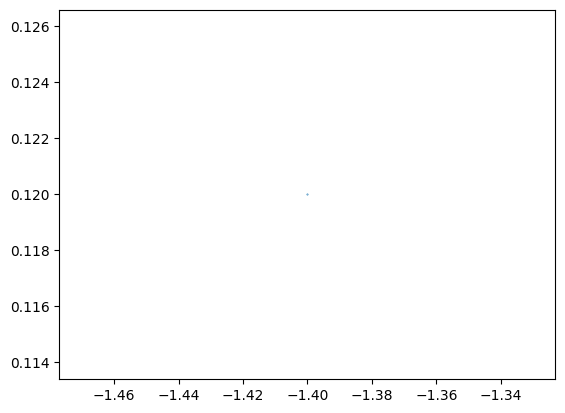

In [26]:
plt.scatter(*seeds[iseed])

In [23]:
iseed

0